# Personality Prediction via CV Analysis

In [1]:
# 0) Setup
# If needed, uncomment to install:
# !pip install pandas numpy scikit-learn joblib tqdm matplotlib
import os, re, json, warnings, joblib
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

DATA_PATH = r"C:\Users\suray\Desktop\personality_prediction_project_flat_artifacts\UpdatedResumeDataSet.csv" 

# Output artifact file names (flat files in current working directory)
TFIDF_PATH = "tfidf_b5.pkl"
MODEL_PATH = "bigfive_ridge.pkl"
LABEL_SCALER_PATH = "label_minmax.pkl"
META_PATH = "meta.json"


In [2]:
# 1) Load & quick look
df = pd.read_csv(DATA_PATH)
print(df.shape)
display(df.head())
display(df['Category'].value_counts().head(10))


(962, 2)


,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."


Category
Java Developer        84
Testing               70
DevOps Engineer       55
Python Developer      48
Web Designing         45
HR                    44
Hadoop                42
Blockchain            40
ETL Developer         40
Operations Manager    40
Name: count, dtype: int64

In [3]:
# 2) Clean text (simple, robust)
def clean_text(x: str) -> str:
    if not isinstance(x, str): return ""
    x = re.sub(r'http\S+', ' ', x)
    x = re.sub(r'[\r\n\t]+', ' ', x)
    x = re.sub(r'[^a-zA-Z ]+', ' ', x)
    x = re.sub(r'\s+', ' ', x).strip().lower()
    return x

df['clean'] = df['Resume'].fillna("").apply(clean_text)
df[['Resume','clean']].head(3)


,Resume,clean
0,Skills * Programming Languages: Python (pandas...,skills programming languages python pandas num...
1,Education Details \r\nMay 2013 to May 2017 B.E...,education details may to may b e uit rgpv data...
2,"Areas of Interest Deep Learning, Control Syste...",areas of interest deep learning control system...


In [4]:
# 3) Lexicon for weak labels (Big Five)
LEX = {
    'O+': {"research","novel","innovative","creative","explore","curious","prototype","design","brainstorm",
           "paper","publication","hypothesis","abstract","conceptual","theory","art","literature"},
    'O-': {"routine","conventional","strictly","unchanged","rote"},
    'C+': {"deadline","on-time","schedule","organized","plan","milestone","deliverable","tested","qa","documentation",
           "audit","checklist","process","quality","accuracy","compliance"},
    'C-': {"delay","messy","late","sloppy","incomplete","improper"},
    'E+': {"led","lead","presented","present","public","network","client-facing","facilitated","hosted","moderated",
           "speaker","outreach","demo","pitch","evangelized"},
    'E-': {"quiet","reserved","introverted","behind-the-scenes"},
    'A+': {"team","collaborate","collaboration","support","helped","volunteer","community","empathy","stakeholder",
           "partnered","coordinated","taught","mentored","peer","service"},
    'A-': {"conflict","argued","blame","criticized","dispute"},
    'N+': {"stress","anxious","overwhelmed","frustrated","nervous","worried"},
    'N-': {"resilient","calm","composed","stable","cope","de-escalate","mindful","poise"}
}
STOP = {"and","the","a","to","of","in","on","for","with","at","by","an","as","is","are","was","were","be","being","been"}

def tokenize(s: str):
    return [w for w in s.split() if len(w) > 2 and w not in STOP]

def bigfive_weak_labels(text: str):
    toks = set(tokenize(text))
    def score(pos_set, neg_set):
        pos = len(toks & pos_set)
        neg = len(toks & neg_set)
        return pos - 0.7*neg
    O = score(LEX['O+'], LEX['O-'])
    C = score(LEX['C+'], LEX['C-'])
    E = score(LEX['E+'], LEX['E-'])
    A = score(LEX['A+'], LEX['A-'])
    N = score(LEX['N+'], LEX['N-'])  # higher means more neurotic signals
    return np.array([O,C,E,A,N], dtype=float)

raw_scores = np.vstack(df['clean'].apply(bigfive_weak_labels).values)
raw_scores[:5], raw_scores.shape


(array([[1. , 1. , 1. , 1.3, 0. ],
        [3. , 0. , 0. , 0. , 0. ],
        [1. , 0. , 1. , 0. , 0. ],
        [1. , 3. , 1. , 3. , 0. ],
        [0. , 0. , 0. , 0. , 0. ]]),
 (962, 5))

In [5]:
# 4) Normalize weak labels to [0,1]
scaler_labels = MinMaxScaler(feature_range=(0,1))
labels_norm = scaler_labels.fit_transform(raw_scores)
labels_norm[:5]


array([[0.36170213, 0.18888889, 0.25      , 0.26      , 0.28571429],
       [0.78723404, 0.07777778, 0.        , 0.        , 0.28571429],
       [0.36170213, 0.07777778, 0.25      , 0.        , 0.28571429],
       [0.36170213, 0.41111111, 0.25      , 0.6       , 0.28571429],
       [0.14893617, 0.07777778, 0.        , 0.        , 0.28571429]])

In [6]:
# 5) TF-IDF features
tfidf = TfidfVectorizer(max_features=8000, ngram_range=(1,2), min_df=2)
X = tfidf.fit_transform(df['clean']).astype(np.float32)
y = labels_norm
X.shape, y.shape


((962, 8000), (962, 5))

In [7]:
# 6) Train multi-output Ridge using solver='lsqr' (avoids sparse_cg SciPy API issue)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = MultiOutputRegressor(Ridge(alpha=2.0, random_state=42, solver='lsqr'))
model.fit(X_train, y_train)
y_pred = np.clip(model.predict(X_test), 0, 1)
print('R2 (avg):', r2_score(y_test, y_pred, multioutput='uniform_average'))
print('MSE (avg):', mean_squared_error(y_test, y_pred))
for i, t in enumerate(["Openness","Conscientiousness","Extraversion","Agreeableness","Neuroticism"]):
    print(f"{t:18s} R2={r2_score(y_test[:,i], y_pred[:,i]):.3f}")


R2 (avg): 0.8958353710390371
MSE (avg): 0.0035264433235187172
Openness           R2=0.874
Conscientiousness  R2=0.947
Extraversion       R2=0.894
Agreeableness      R2=0.931
Neuroticism        R2=0.833


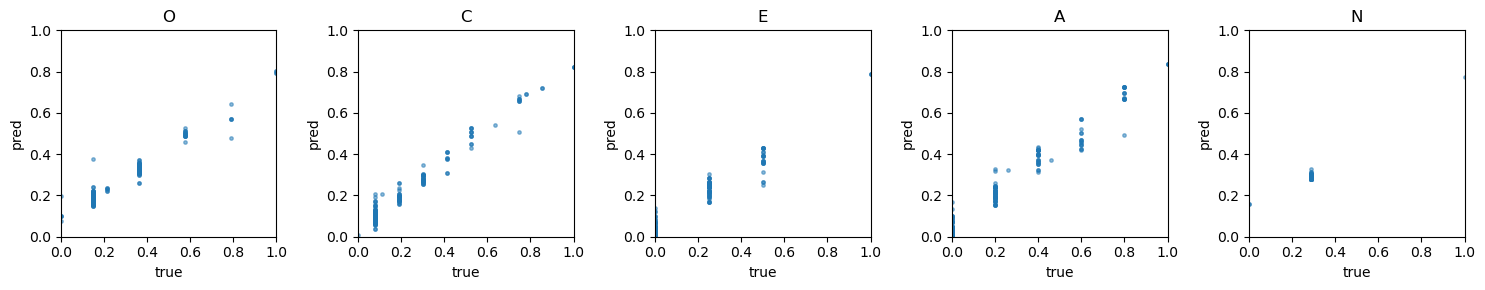

In [8]:
# 7) Quick sanity plots
traits = ["O","C","E","A","N"]
fig, axes = plt.subplots(1,5, figsize=(15,3))
for i,ax in enumerate(axes):
    ax.scatter(y_test[:,i], y_pred[:,i], s=6, alpha=0.5)
    ax.set_title(traits[i]); ax.set_xlabel('true'); ax.set_ylabel('pred')
    ax.set_xlim(0,1); ax.set_ylim(0,1)
plt.tight_layout(); plt.show()


In [9]:
# 8) Save artifacts as flat files (no folder)
joblib.dump(tfidf, TFIDF_PATH)
joblib.dump(model, MODEL_PATH)
joblib.dump(scaler_labels, LABEL_SCALER_PATH)
meta = {
    'labels': ["Openness","Conscientiousness","Extraversion","Agreeableness","Neuroticism"],
    'vectorizer': 'tfidf',
    'model': 'ridge_multioutput_lsqr',
    'note': 'Trained on weak labels from lexicon',
    'files': [TFIDF_PATH, MODEL_PATH, LABEL_SCALER_PATH]
}
json.dump(meta, open(META_PATH,'w'), indent=2)
print('Saved:', TFIDF_PATH, MODEL_PATH, LABEL_SCALER_PATH, META_PATH)


Saved: tfidf_b5.pkl bigfive_ridge.pkl label_minmax.pkl meta.json


In [10]:
# 9) Inference helper
def predict_bigfive_from_resume(text: str):
    cleaned = clean_text(text)
    vec = tfidf.transform([cleaned])
    preds = np.clip(model.predict(vec)[0], 0, 1)
    return {
        'Openness': preds[0],
        'Conscientiousness': preds[1],
        'Extraversion': preds[2],
        'Agreeableness': preds[3],
        'Neuroticism': preds[4]
    }
print(predict_bigfive_from_resume(df.iloc[0]['Resume']))


{'Openness': 0.3602098462250541, 'Conscientiousness': 0.22766205328275116, 'Extraversion': 0.25007351061782546, 'Agreeableness': 0.32193505074137363, 'Neuroticism': 0.28924341286753674}
